In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import ListedColormap, Normalize
from matplotlib.cm import ScalarMappable
plt.style.use('seaborn-v0_8-poster')

from ax.service.ax_client import AxClient
from ax.utils.notebook.plotting import render, init_notebook_plotting
from ax.storage.json_store.load import load_experiment

import KCutils.bayesian_optimization as KC_BO

init_notebook_plotting()

base_path = './trials'

Fontsize = 16 # default font size for plots
Lwidth = 1.5 # default line width for plots
Msize = 6 # default marker size for plots

### SETUP: do not edit below this line, otherwise the reproducibility of the results is not guaranteed
## setup for establishing plotting defaults
lines = {'linewidth' : Lwidth,
         'markersize': Msize,
         'markeredgewidth': Lwidth,
        }
plt.rc('lines', **lines)
font = {'family' : 'serif',
        'serif'  : 'Times',
        'size'   : Fontsize}
plt.rc('font', **font)  # pass in the font dict as kwargs

[INFO 12-06 12:03:31] ax.utils.notebook.plotting: Injecting Plotly library into cell. Do not overwrite or delete cell.


In [2]:
# folder names of stored data from trials
# 2023_03_24_17h50m07s - switching with two initial data points
# 2023_03_22_12h45m59s - restricted only
# 2023_03_22_12h50m21s - relaxed only
data_list = [
    "2023_03_24_17h50m07s",
    "2023_03_22_12h45m59s",
    "2023_03_22_12h50m21s",
]

subtitles = ["(a) SEBO", "(b) Safe BO", "(c) Relaxed Safe BO"]

Linear Model to be used for CONTROL:
A:  [[1.00268351 0.0175441 ]
 [0.13155243 0.34256854]]
B:  [[ 0.58145481 -0.22042118]
 [ 2.67365891 -1.13104991]]
C:  [[1 0]
 [0 1]]
xss:  [33.306       7.73575879]

Linear Model to be used for the PLANT:
A:  [[0.88754486 0.05459241]
 [0.09345649 0.28265964]]
B:  [[ 0.50282961 -0.17397488]
 [ 2.7636534  -1.03664163]]
C:  [[1 0]
 [0 1]]
xss:  [33.306       7.73575879]


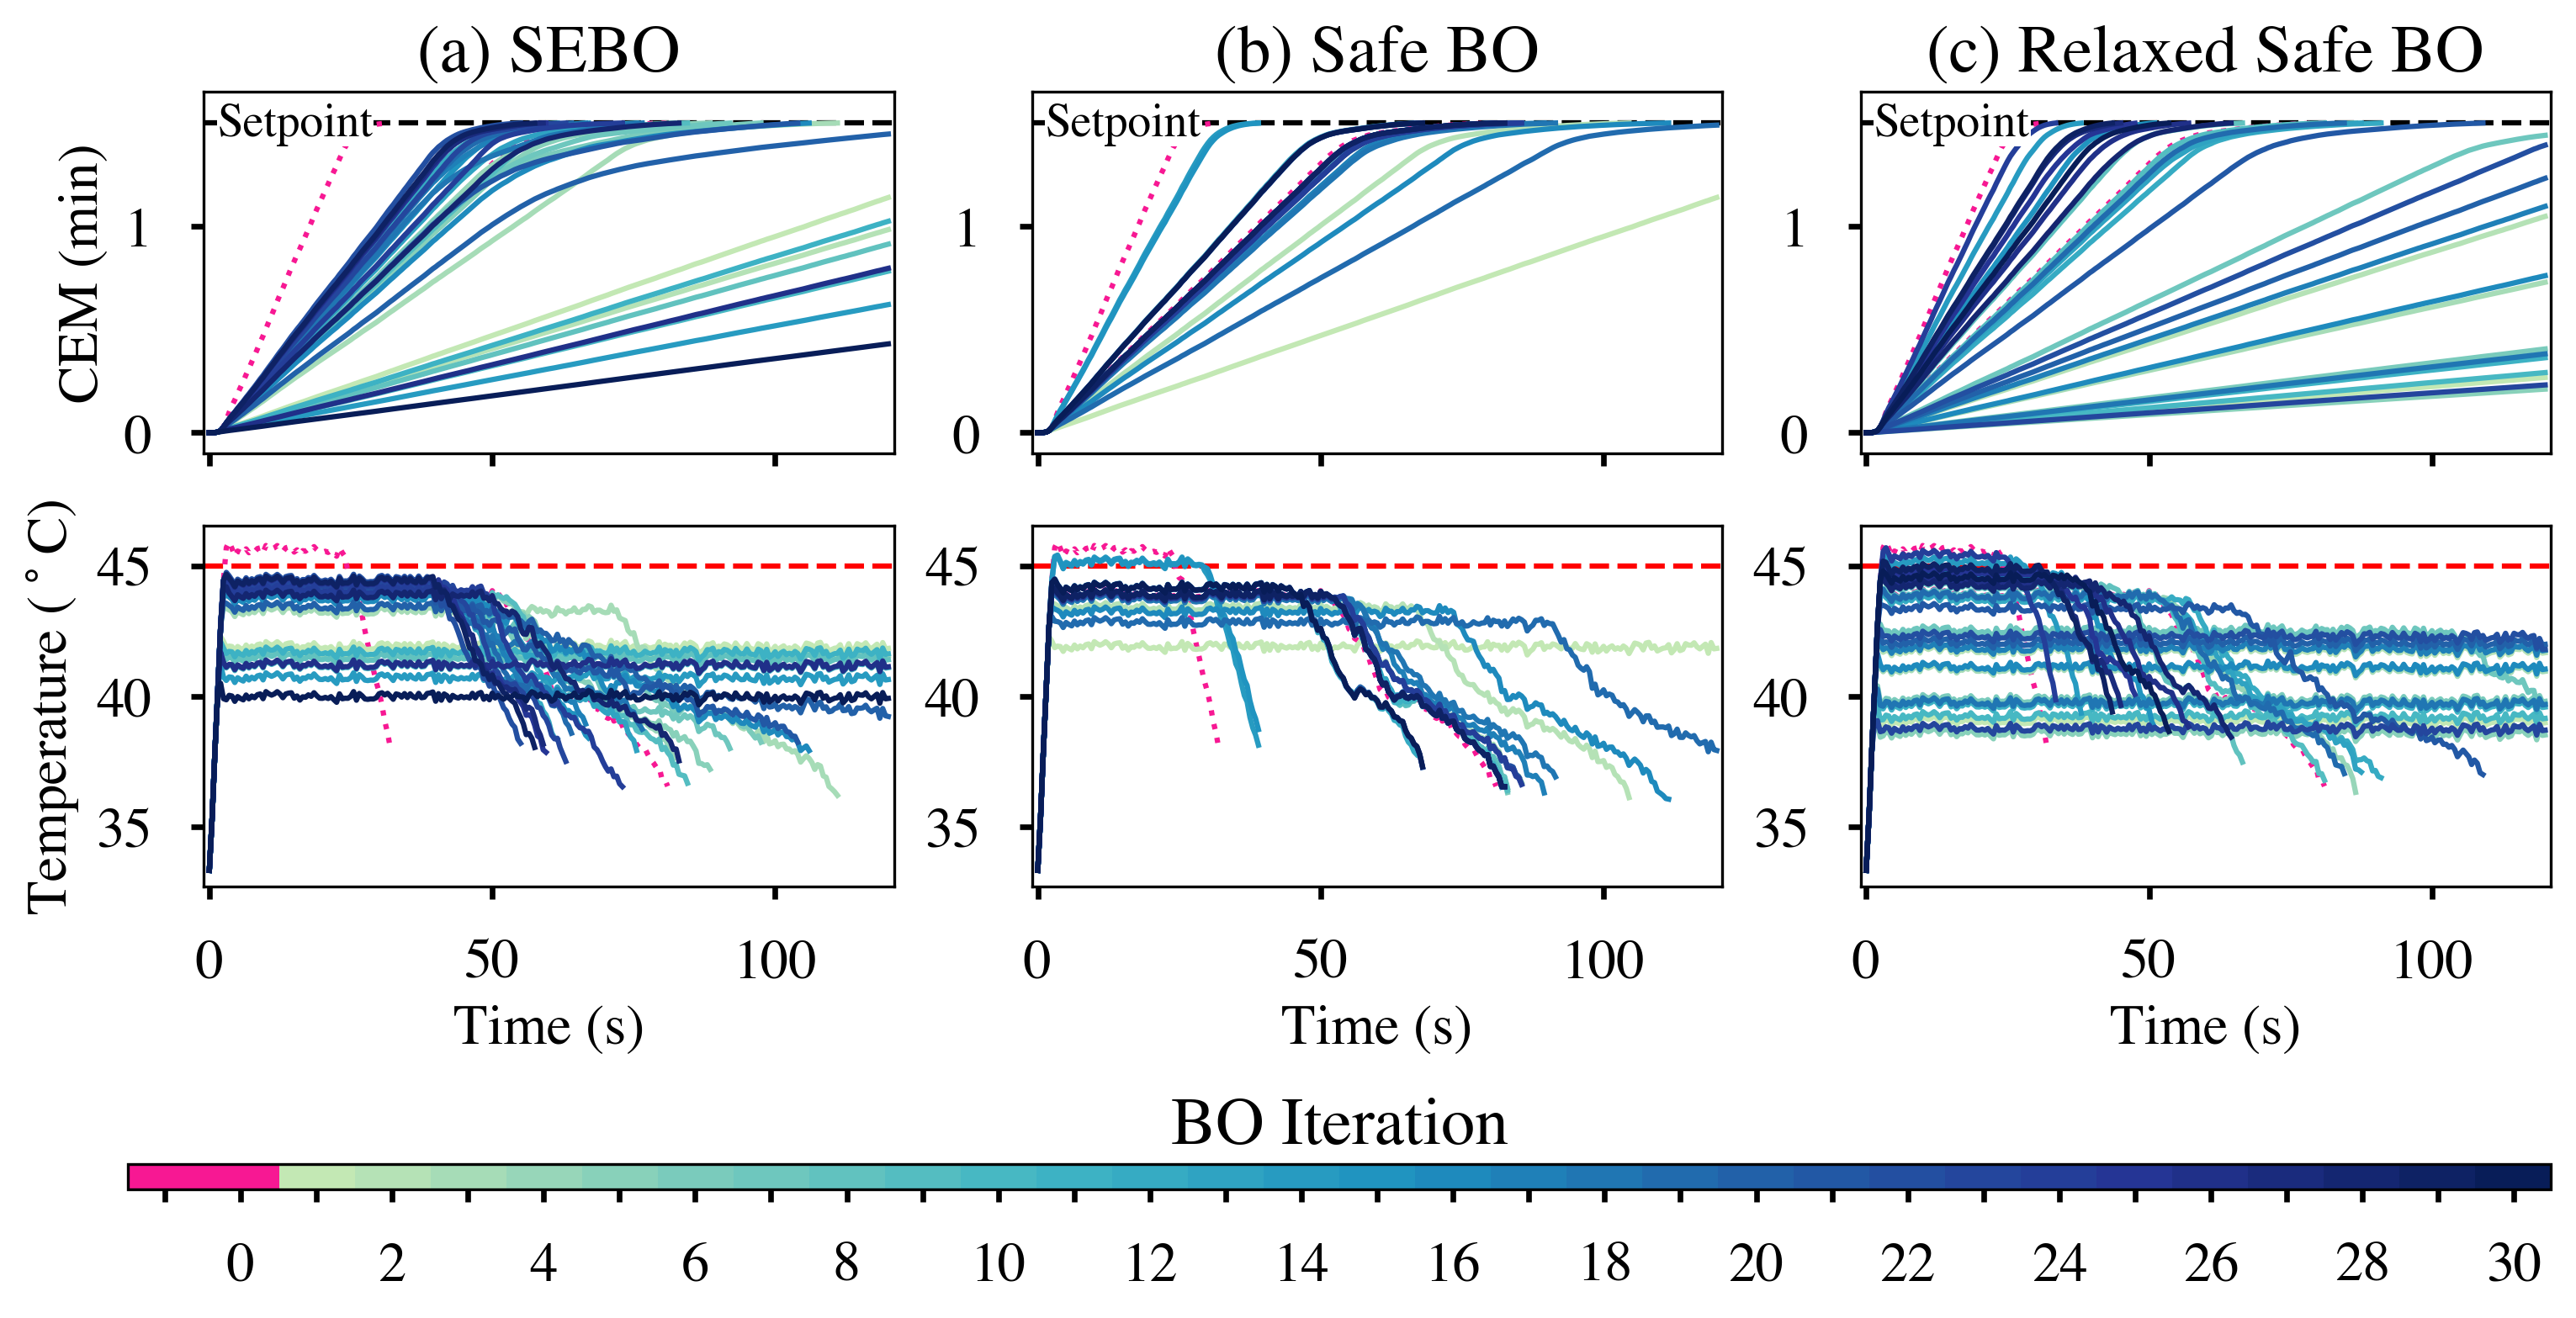

In [9]:
from config.economic import get_prob_info
# switch to highlight the incumbent best (defined as the lowest treatment time without violating constraints) in the final figure
plot_best = False

N_bo_iter = 30
n_mc = 1
ts = 0.5
n_add = 1

# colors for the figures
pink = np.array([248 / 256, 24 / 256, 148 / 256, 1.0])
green = np.array([0.0, 1.0, 0.0, 1.0])
cyan = np.array([0.0, 1.0, 1.0, 1.0])

if plot_best:
    alpha = 0.2
else:
    alpha = 1.0

end_cutoff = 121.0
prob_info = get_prob_info(COLAB=False)
fig, ((ax11, ax12, ax13), (ax21, ax22, ax23)) = plt.subplots(
    2,
    len(data_list),
    figsize=(12, 5),
    dpi=300,
    sharex=True,
)
cem_ax = [ax11, ax12, ax13]
temp_ax = [ax21, ax22, ax23]
# fig.suptitle('Observed Trajectories')
ax11.set_ylabel("CEM (min)")
ax21.set_ylabel("Temperature ($^\circ$C)")

for timestamp, ax1, ax2, subtitle in zip(data_list, cem_ax, temp_ax, subtitles):
    # determine number of total iterations
    total_iters = N_bo_iter + n_add + 1

    # create colormap corresponding to total iterations
    n_cm_samp = int(np.ceil(total_iters * 1.25))
    purples = mpl.colormaps["YlGnBu"].resampled(n_cm_samp)
    newcolors = purples(np.linspace(0, 1, n_cm_samp))
    newcolors = newcolors[-total_iters:, :]
    newcolors[: n_add + 1, :] = pink
    newcmp = ListedColormap(newcolors)

    # plot the base features of the plot (e.g., target values, constraints, etc.)
    ax1.axhline(1.5, color="k", linestyle="--", label="Setpoint")
    #     ax1.set_xlabel('Time (s)')
    #     ax1.legend(loc='upper right', fontsize='x-small')
    ax1.set_xlim([-1.0, end_cutoff])
    ax1.set_ylim([-0.1, 1.65])
    ax1.set_title(subtitle)
    bbox_dict = dict(facecolor="w", edgecolor="w", boxstyle="Square,pad=0.0")
    ax1.text(
        0.02,
        0.97,
        "Setpoint",
        color="k",
        fontsize="small",
        horizontalalignment="left",
        verticalalignment="top",
        transform=ax1.transAxes,
        bbox=bbox_dict,
    )
    Tmax = prob_info["x_max"][0] + prob_info["xss"][0]
    ax2.axhline(Tmax, color="r", linestyle="--", label="Constraint")
    ax2.set_xlabel("Time (s)")
    ax2.set_xlim([-1.0, end_cutoff])

    best_CEMplot = []
    best_Tplot = []
    prev_st = end_cutoff * 2
    for n in range(n_mc):
        for i in range(total_iters):
            cl_data_file = (
                base_path + "/" + timestamp + f"/cl_data/trial{n}_iter{i}_sim_data.npy"
            )

            d = np.load(cl_data_file, allow_pickle=True).item()

            s1 = d["rep0"]["sim_data"]
            s2 = d["rep1"]["sim_data"]
            s3 = d["rep2"]["sim_data"]

            st = s1["CEM_stop_time"]
            CEMplot = s1["CEMsim"][0, :st]
            Tplot = s1["Ysim"][0, :st] + prob_info["xss"][0]
            Pplot = s1["Usim"][0, : (st - 1)] + prob_info["uss"][0]
            qplot = s1["Usim"][1, : (st - 1)] + prob_info["uss"][1]

            if (st < prev_st) and np.sum(np.maximum(Tplot - Tmax, 0)) <= 1e-10:
                best_CEMplot = CEMplot
                best_Tplot = Tplot
                prev_st = st

            if i <= n_add:
                ax1.plot(
                    np.arange(len(CEMplot)) * ts,
                    CEMplot,
                    ls=":",
                    c=newcmp(i),
                    alpha=alpha,
                )
                ax2.plot(
                    np.arange(len(Tplot)) * ts, Tplot, ls=":", c=newcmp(i), alpha=alpha
                )
            else:
                ax1.plot(
                    np.arange(len(CEMplot)) * ts, CEMplot, c=newcmp(i), alpha=alpha
                )
                ax2.plot(np.arange(len(Tplot)) * ts, Tplot, c=newcmp(i), alpha=alpha)

    if plot_best:
        ax1.plot(
            np.arange(len(best_CEMplot)) * ts, best_CEMplot, c="tab:orange", alpha=0.8
        )
        ax2.plot(np.arange(len(best_Tplot)) * ts, best_Tplot, c="tab:orange", alpha=0.8)

    plt.draw()

# plt.tight_layout()
fig.subplots_adjust(bottom=0.25)
cb_ax = fig.add_axes([0.1, 0.01, 0.8, 0.02])
cb_ax.set_title("BO Iteration")
mappable = ScalarMappable(norm=Normalize(0, total_iters), cmap=newcmp)
mappable.set_array([])
mappable.set_clim(-0.5, total_iters + 0.5)
cbar = fig.colorbar(mappable, location="bottom", cax=cb_ax)
cbar.set_ticks(np.linspace(0, total_iters, total_iters))
num_labels = list(range(0, total_iters, 2))
blank_labels = ["" for _ in num_labels]
cbar_labels = [
    *[""],
    *[item for pair in zip(num_labels, blank_labels) for item in pair],
]
cbar.set_ticklabels(cbar_labels[:-1])

save_name = (
    f"./figures/poster/comparison-{data_list[0]}-{data_list[1]}-{data_list[2]}-best.jpg"
    if plot_best
    else f"./figures/poster/comparison-{data_list[0]}-{data_list[1]}-{data_list[2]}.jpg"
)

fig.savefig(
    save_name,
    dpi=300,
    bbox_inches="tight",
)

plt.show()

Linear Model to be used for CONTROL:
A:  [[1.00268351 0.0175441 ]
 [0.13155243 0.34256854]]
B:  [[ 0.58145481 -0.22042118]
 [ 2.67365891 -1.13104991]]
C:  [[1 0]
 [0 1]]
xss:  [33.306       7.73575879]

Linear Model to be used for the PLANT:
A:  [[0.88754486 0.05459241]
 [0.09345649 0.28265964]]
B:  [[ 0.50282961 -0.17397488]
 [ 2.7636534  -1.03664163]]
C:  [[1 0]
 [0 1]]
xss:  [33.306       7.73575879]


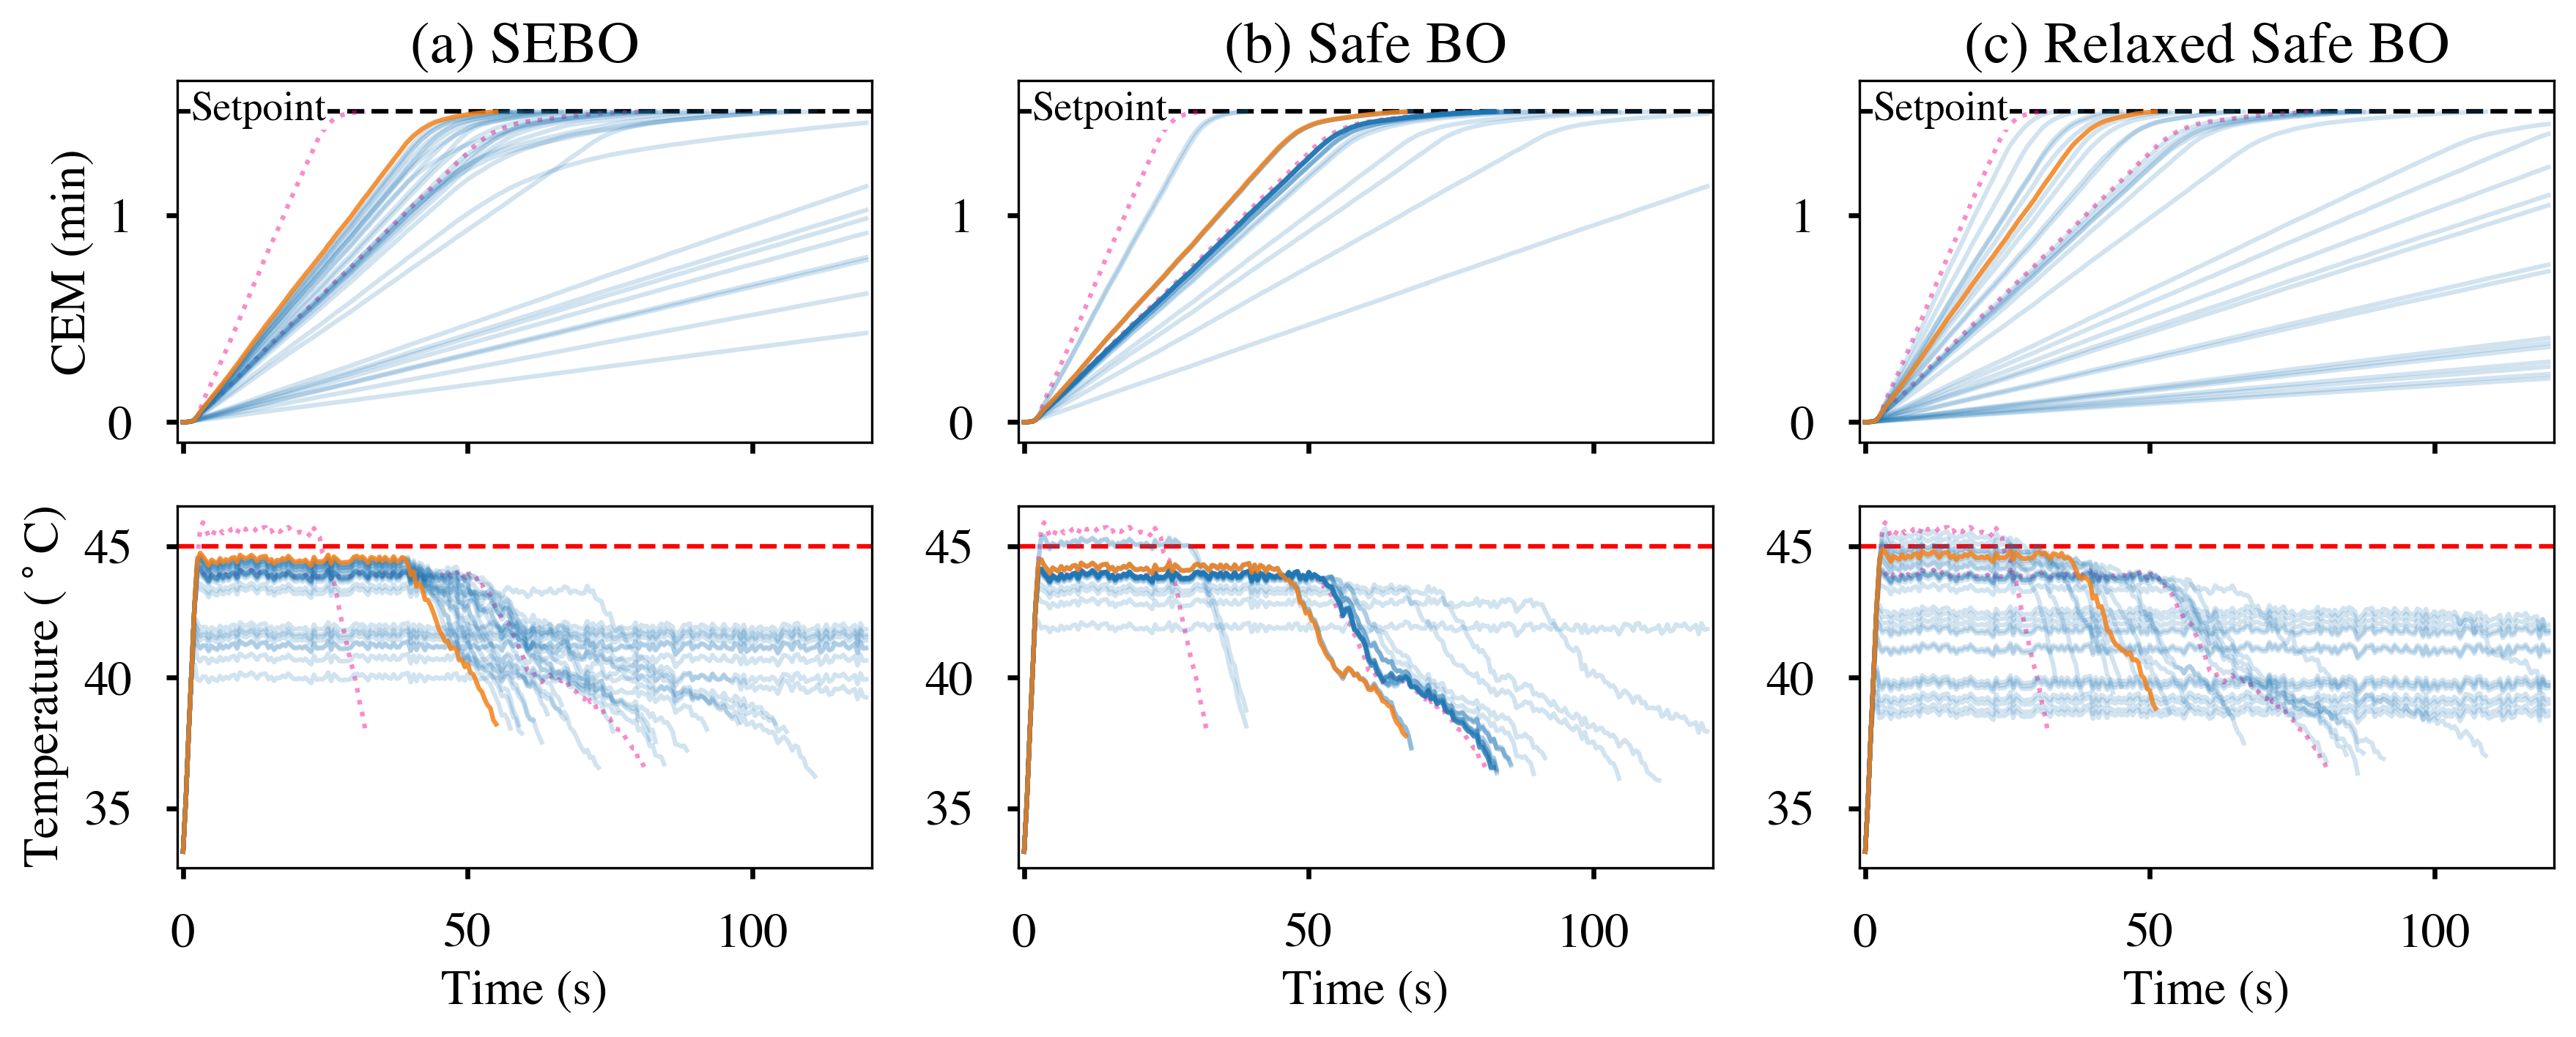

In [4]:
from config.economic import get_prob_info

N_bo_iter = 30
n_mc = 1
ts = 0.5
n_add = 1

pink = np.array([248 / 256, 24 / 256, 148 / 256, 1.0])
green = np.array([0.0, 1.0, 0.0, 1.0])
cyan = np.array([0.0, 1.0, 1.0, 1.0])

end_cutoff = 121.0
prob_info = get_prob_info(COLAB=False)
fig, ((ax11, ax12, ax13), (ax21, ax22, ax23)) = plt.subplots(
    2,
    len(data_list),
    figsize=(12, 5),
    dpi=300,
    sharex=True,
)
cem_ax = [ax11, ax12, ax13]
temp_ax = [ax21, ax22, ax23]
# fig.suptitle('Observed Trajectories')
ax11.set_ylabel("CEM (min)")
ax21.set_ylabel("Temperature ($^\circ$C)")

for timestamp, ax1, ax2, subtitle in zip(data_list, cem_ax, temp_ax, subtitles):
    # determine number of total iterations
    total_iters = N_bo_iter + n_add + 1

    # plot the base features of the plot (e.g., target values, constraints, etc.)
    ax1.axhline(1.5, color="k", linestyle="--", label="Setpoint")
    #     ax1.set_xlabel('Time (s)')
    #     ax1.legend(loc='upper right', fontsize='x-small')
    ax1.set_xlim([-1.0, end_cutoff])
    ax1.set_ylim([-0.1, 1.65])
    ax1.set_title(subtitle)
    bbox_dict = dict(facecolor="w", edgecolor="w", boxstyle="Square,pad=0.0")
    ax1.text(
        0.02,
        0.97,
        "Setpoint",
        color="k",
        fontsize="small",
        horizontalalignment="left",
        verticalalignment="top",
        transform=ax1.transAxes,
        bbox=bbox_dict,
    )
    Tmax = prob_info["x_max"][0] + prob_info["xss"][0]
    ax2.axhline(
        Tmax,
        color="r",
        linestyle="--",
        label="Constraint",
    )
    ax2.set_xlabel("Time (s)")
    ax2.set_xlim([-1.0, end_cutoff])

    best_CEMplot = []
    best_Tplot = []
    prev_st = end_cutoff*2
    for n in range(n_mc):
        for i in range(total_iters):
            cl_data_file = (
                base_path + "/" + timestamp + f"/cl_data/trial{n}_iter{i}_sim_data.npy"
            )

            d = np.load(cl_data_file, allow_pickle=True).item()

            s1 = d["rep0"]["sim_data"]
            s2 = d["rep1"]["sim_data"]
            s3 = d["rep2"]["sim_data"]

            st = s1["CEM_stop_time"]
            CEMplot = s1["CEMsim"][0, :st]
            Tplot = s1["Ysim"][0, :st] + prob_info["xss"][0]
            Pplot = s1["Usim"][0, : (st - 1)] + prob_info["uss"][0]
            qplot = s1["Usim"][1, : (st - 1)] + prob_info["uss"][1]

            if (st < prev_st) and np.sum(np.maximum(Tplot-Tmax,0)) <= 1e-10:
                best_CEMplot = CEMplot
                best_Tplot = Tplot 
                prev_st = st

            if i <= n_add:
                ax1.plot(np.arange(len(CEMplot)) * ts, CEMplot, ls=":", c=pink, alpha=0.5)
                ax2.plot(np.arange(len(Tplot)) * ts, Tplot, ls=":", c=pink, alpha=0.5)
            else:
                ax1.plot(np.arange(len(CEMplot)) * ts, CEMplot, c='tab:blue', alpha=0.2)
                ax2.plot(np.arange(len(Tplot)) * ts, Tplot, c='tab:blue', alpha=0.2)

    ax1.plot(np.arange(len(best_CEMplot)) * ts, best_CEMplot, c='tab:orange', alpha=0.8)
    ax2.plot(np.arange(len(best_Tplot)) * ts, best_Tplot, c='tab:orange', alpha=0.8)
    plt.draw()

plt.tight_layout()

fig.savefig(
    f"./figures/presentation/comparison-{data_list[0]}-{data_list[1]}-{data_list[2]}.jpg",
    dpi=300,
    bbox_inches="tight",
)

plt.show()

In [4]:
timestamp = data_list[0]
ax_client = AxClient.load_from_json_file(base_path+'/'+timestamp+'/ax_client_snapshot0.json')

[INFO 04-05 12:35:22] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.


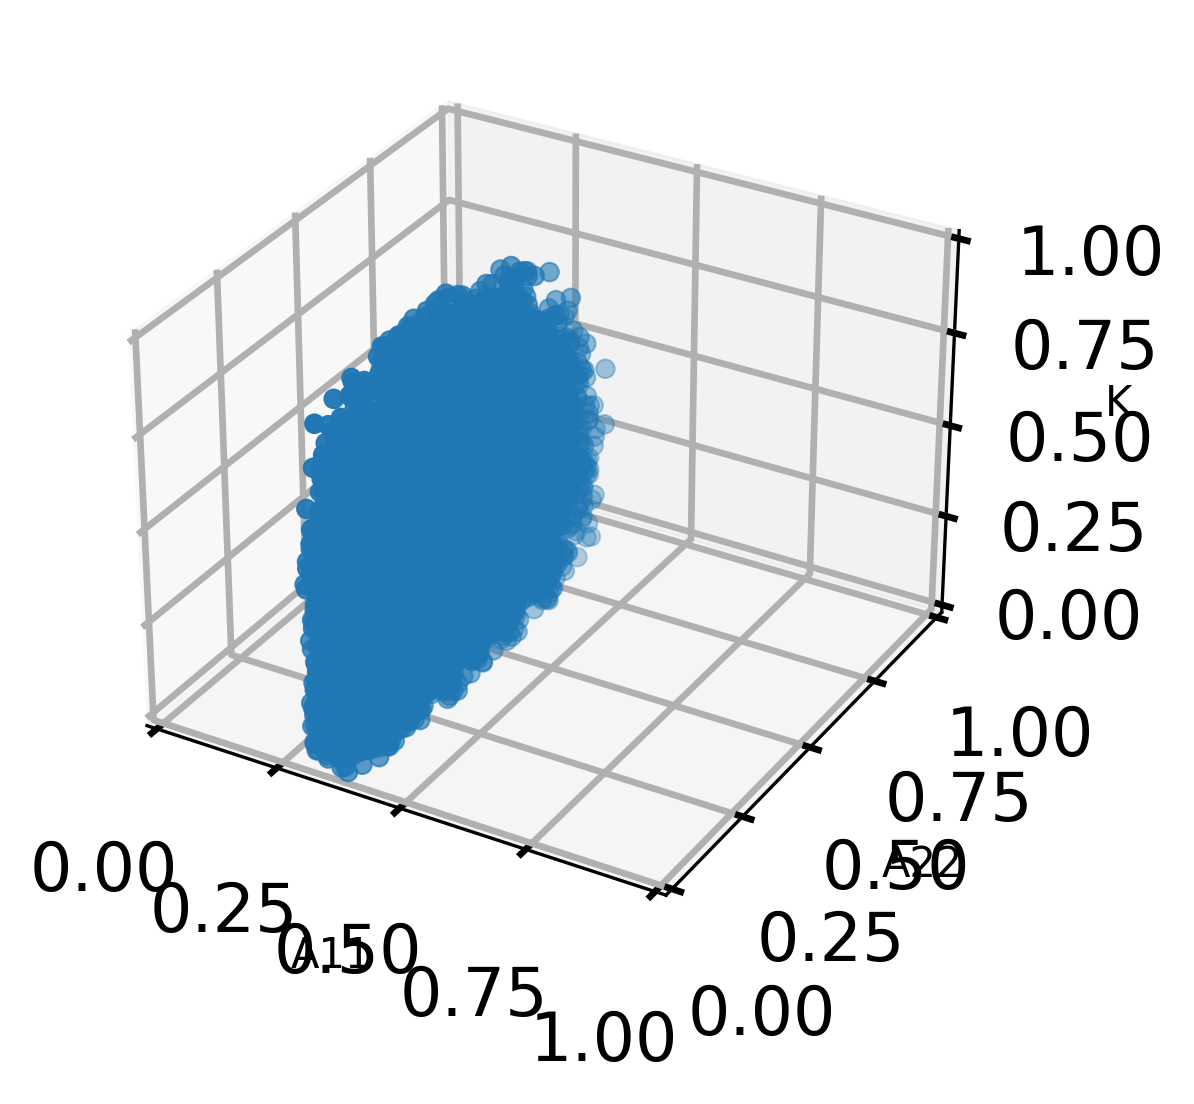

In [ ]:
projection_data = ax_client.get_trial(31).generator_run.gen_metadata["projection_data"]
estimated_safe_set = projection_data["estimated_safe_set"]

fig2 = plt.figure(figsize=(4,4), dpi=300)
ax = fig2.add_subplot(projection='3d')
ax.scatter(estimated_safe_set[:,0], estimated_safe_set[:,2], estimated_safe_set[:,4], marker='o')
ax.set_xlabel('A11'); ax.set_xlim([0.0,1.0])
ax.set_ylabel('A22'); ax.set_ylim([0.0,1.0])
ax.set_zlabel('K'); ax.set_zlim([0.0,1.0])
plt.show()

In [6]:
ax_client.get_trial(31).generator_run.model_predictions

[{'obj2': [-0.5026081014938311], 'obj1': [-372.6040903853385]},
 {'obj2': {'obj2': [1.7120656829138758], 'obj1': [0.0]},
  'obj1': {'obj2': [0.0], 'obj1': [556.7908354962789]}}]

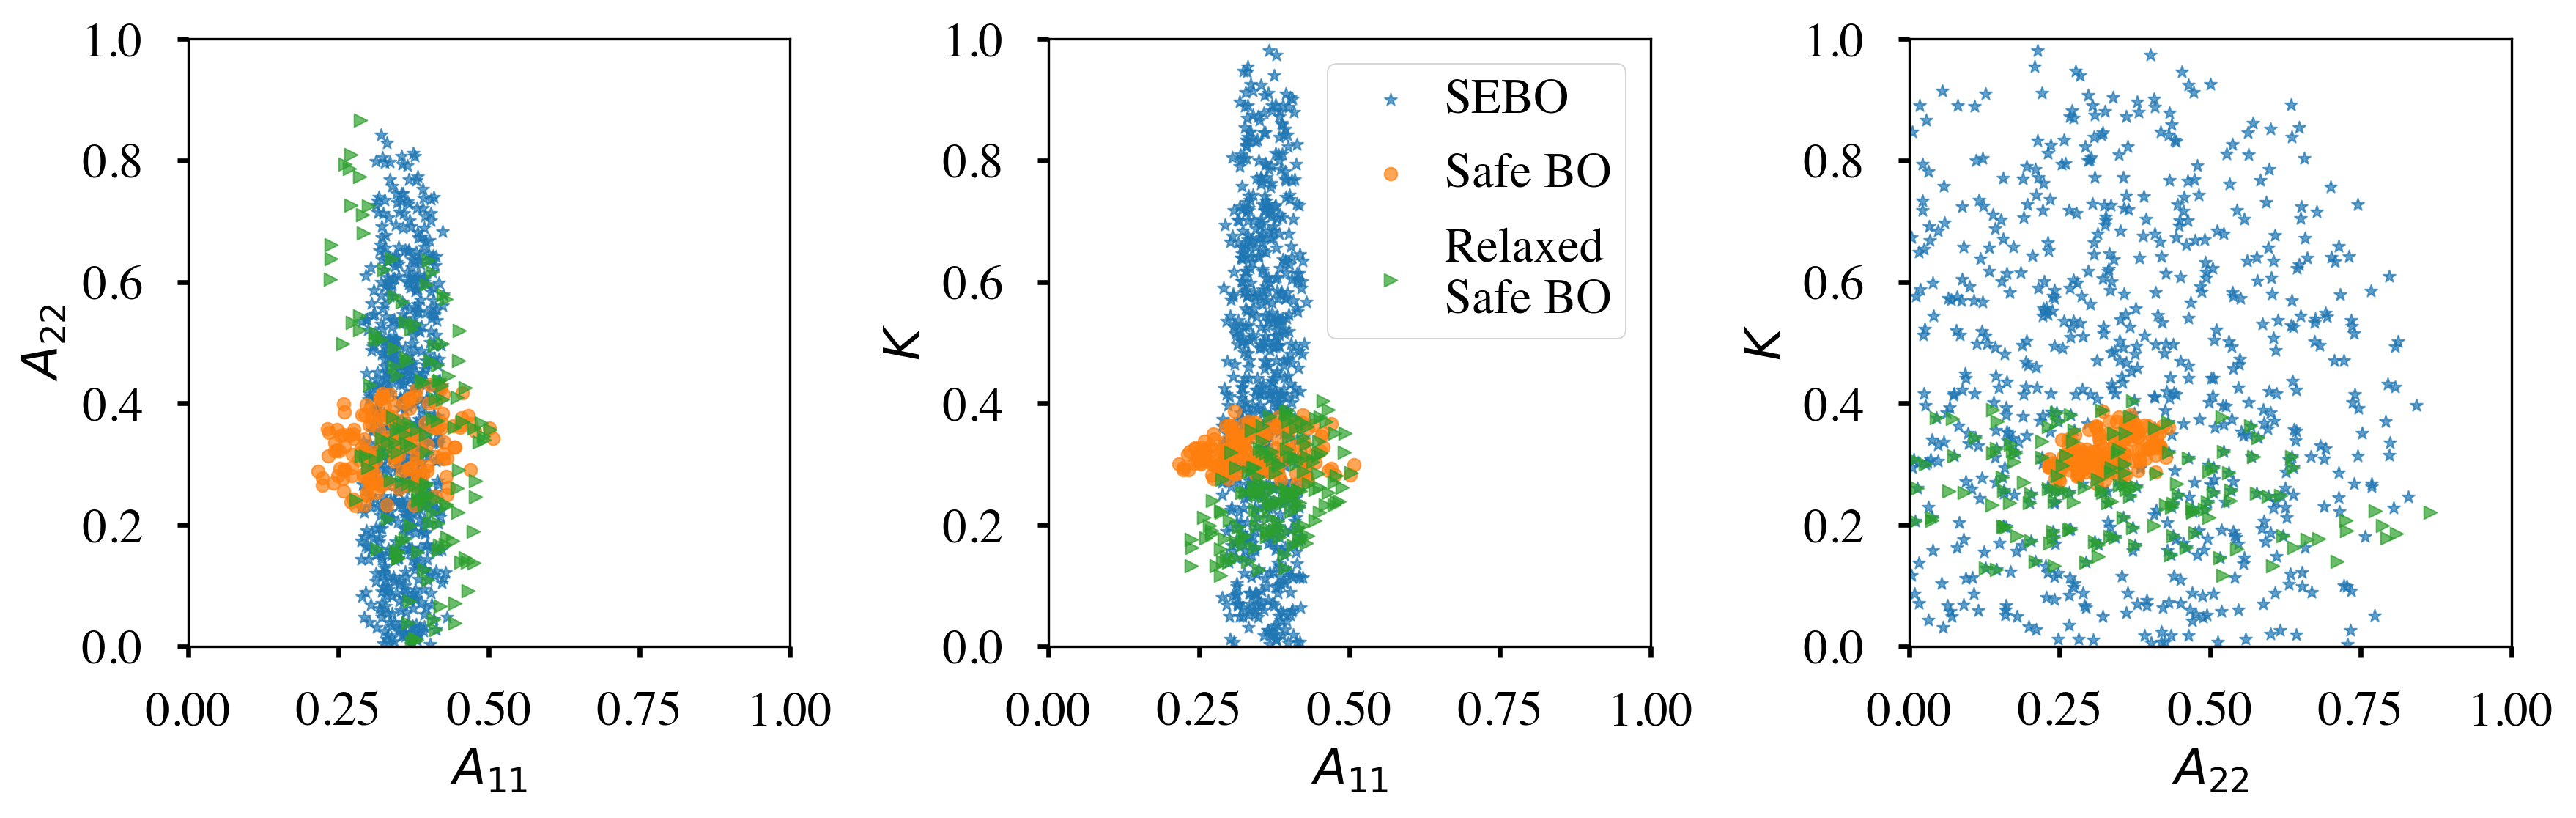

In [6]:
import torch

def get_est_safe_set(botorch_model, n_samp=int(1e5)):
    rng = np.random.default_rng(42)
#     print(botorch_model._search_space_digest)
    bounds = botorch_model._search_space_digest.bounds
    beta = np.sqrt(botorch_model.acquisition_options["barrier_beta"]*np.pi/2)
    cons_tol = -1e-1
    rand_candidates = []
    for i,bound_i in enumerate(bounds):
        # get random samples
        rsamps = rng.random(size=(n_samp,1))
        # scale the random samples to the bounds
        l,u = bound_i
        scaled_samp = (u-l)*rsamps + l
        rand_candidates.append(scaled_samp)
    rand_candidates = np.hstack(rand_candidates)
    rand_candidates = torch.tensor(rand_candidates) # change to torch.tensor for GP prediction step

    # check which samples are safe to create an estimated safe set
    frand, covrand = botorch_model.predict(rand_candidates)
    cons_bound_est = frand[:,1:] - beta * torch.diagonal(covrand[:,1:,1:], dim1=-2, dim2=-1)
#     print(cons_bound_est)
    cons_satisfy = torch.all(cons_bound_est >= cons_tol, dim=1)
    rand_cand_safe = rand_candidates[cons_satisfy,:]
    return rand_cand_safe
    
depthshade = True # whether or not to shade markers based on depth
threeD = False # whether to plot 3D or not
norm_limits = [-0.0,1.0]
fig3 = plt.figure(figsize=(12,4), dpi=300, layout='tight')
msize = 18

if threeD:
    ax1 = fig3.add_subplot(1,3,1,projection='3d')
    ax1.view_init(elev=90, azim=-90, roll=0) #XY
    ax2 = fig3.add_subplot(1,3,2,projection='3d')
    ax2.view_init(elev=0, azim=-90, roll=0) #XZ
    ax3 = fig3.add_subplot(1,3,3,projection='3d')
    ax3.view_init(elev=0, azim=0, roll=0) #YZ
else:
    ax1 = fig3.add_subplot(1,3,1)
    ax2 = fig3.add_subplot(1,3,2)
    ax3 = fig3.add_subplot(1,3,3)
    
for timestamp,m,n_samp in zip(data_list, ['*', 'o', '>'], [int(1e4), int(1e6), int(1e4)]):
    ax_client = AxClient.load_from_json_file(base_path+'/'+timestamp+'/ax_client_snapshot0.json', verbose_logging=False)
    botorch_model = ax_client.generation_strategy._model.model
    safe_set = get_est_safe_set(botorch_model,n_samp)
    if threeD:
        ax1.scatter(safe_set[:,0], safe_set[:,2], safe_set[:,4], marker=m, s=msize, depthshade=depthshade)
        ax2.scatter(safe_set[:,0], safe_set[:,2], safe_set[:,4], marker=m, s=msize, depthshade=depthshade)
        ax3.scatter(safe_set[:,0], safe_set[:,2], safe_set[:,4], marker=m, s=msize, depthshade=depthshade)
    else:
        ax1.scatter(safe_set[:,0], safe_set[:,2], marker=m, s=msize, alpha=0.7)
        ax2.scatter(safe_set[:,0], safe_set[:,4], marker=m, s=msize, alpha=0.7)
        ax3.scatter(safe_set[:,2], safe_set[:,4], marker=m, s=msize, alpha=0.7)
#     print(safe_set)

if threeD:
    ax1.set_xlabel('$A_{11}$'); ax1.set_xlim(norm_limits)
    ax1.set_ylabel('$A_{22}$'); ax1.set_ylim(norm_limits)
    # ax1.set_zlabel('$K$'); ax1.set_zlim(norm_limits)
    ax2.set_xlabel('$A_{11}$'); ax2.set_xlim(norm_limits)
    # ax2.set_ylabel('$A_{22}$'); ax2.set_ylim(norm_limits)
    ax2.set_zlabel('$K$'); ax2.set_zlim(norm_limits)
    # ax3.set_xlabel('$A_{11}$'); ax3.set_xlim(norm_limits)
    ax3.set_ylabel('$A_{22}$'); ax3.set_ylim(norm_limits)
    ax3.set_zlabel('$K$'); ax3.set_zlim(norm_limits)
else:
    ax1.set_xlabel('$A_{11}$'); ax1.set_xlim(norm_limits)
    ax1.set_ylabel('$A_{22}$'); ax1.set_ylim(norm_limits)
    ax2.set_xlabel('$A_{11}$'); ax2.set_xlim(norm_limits)
    ax2.set_ylabel('$K$'); ax2.set_ylim(norm_limits)
    ax3.set_xlabel('$A_{22}$'); ax3.set_xlim(norm_limits)
    ax3.set_ylabel('$K$'); ax3.set_ylim(norm_limits)

ax2.legend(['SEBO', 'Safe BO', 'Relaxed\nSafe BO'],
           handletextpad=0.1,
           borderpad=0.3,
           labelspacing=0.6,
          )
    
fig3.savefig(f'./figures/poster/safe-set-comparison-{data_list[0]}-{data_list[1]}-{data_list[2]}.jpg',
            dpi=300, bbox_inches='tight')

plt.show()

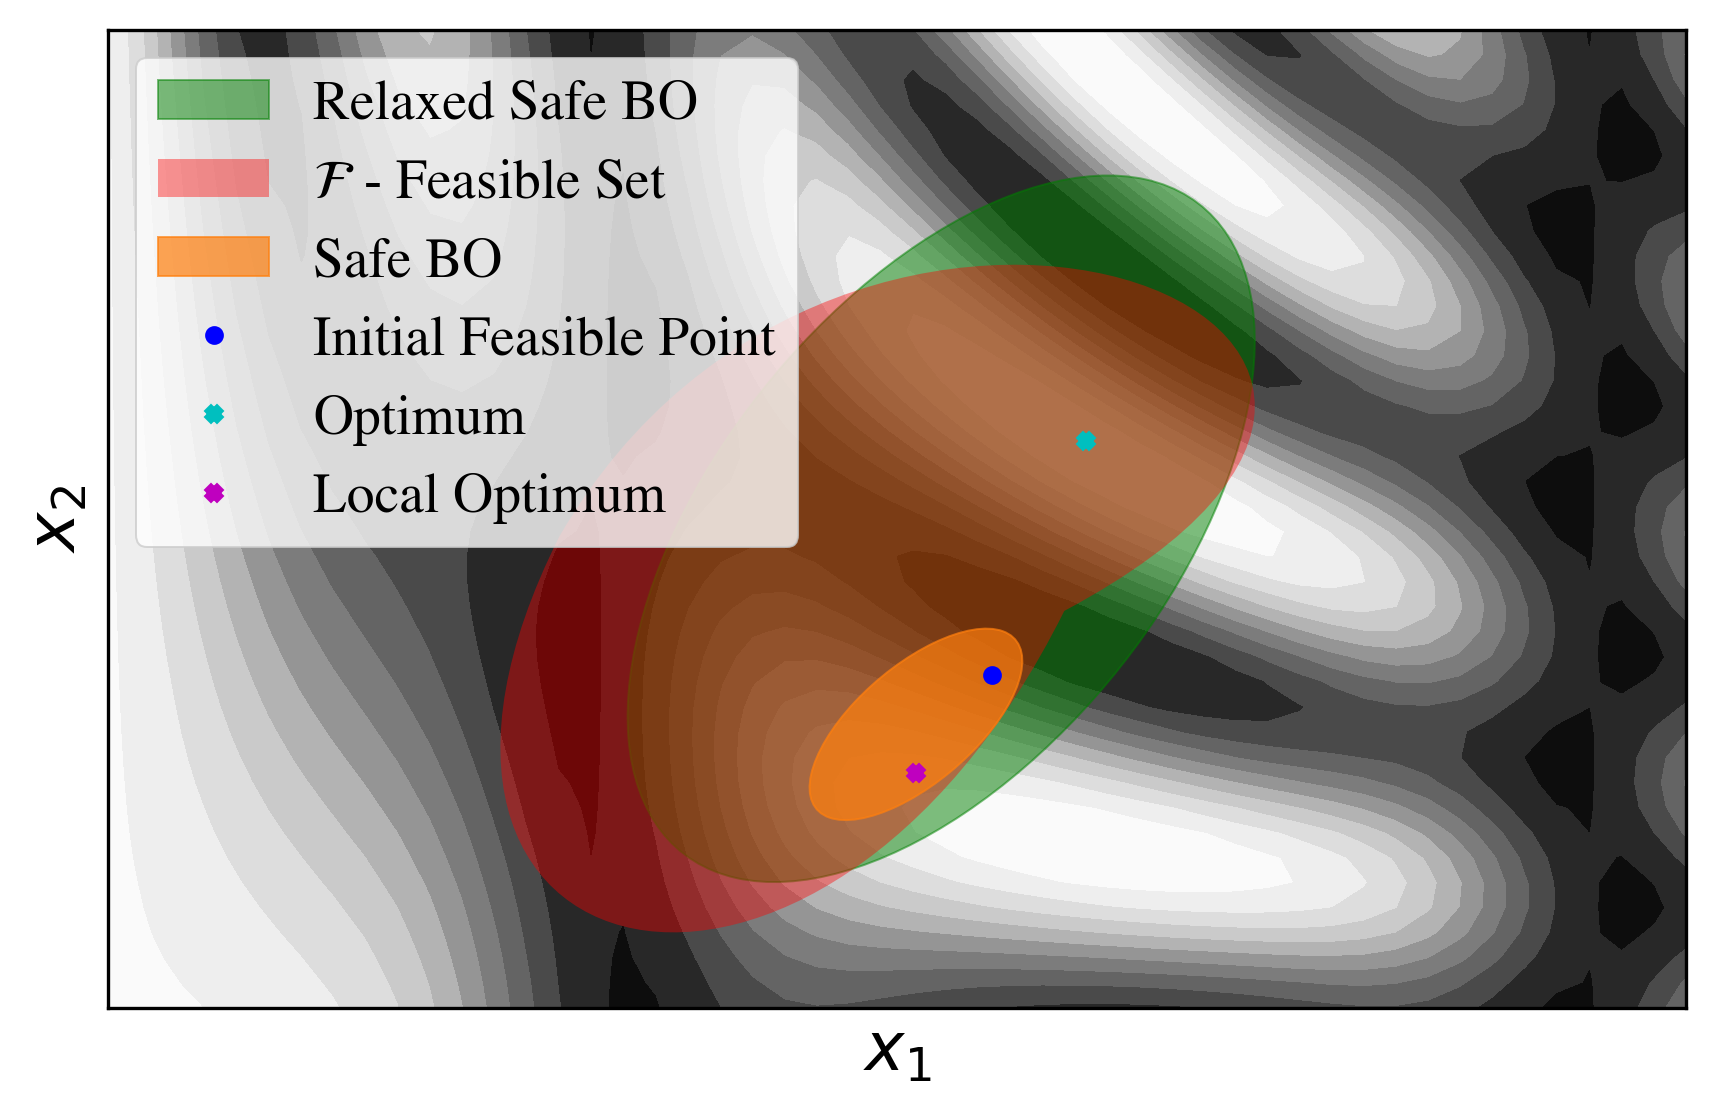

In [18]:
import matplotlib.path as mpath
import matplotlib.patches as mpatches

fig, ax = plt.subplots(dpi=300, figsize=(6,4))

def f(x, y):
    return np.sin(x) ** 10 + np.cos(10 + y * x) * np.cos(x)

x = np.linspace(0, 5, 50)
y = np.linspace(0, 5, 40)

X, Y = np.meshgrid(x, y)
Z = f(X, Y)

contours = None
contours = ax.contourf(X, Y, Z, 10, cmap='Greys')

relaxedbo = mpatches.Ellipse(xy=[2.64,2.45], height=3.8, width=1.6, angle=-20, 
                           alpha=0.5, label='Relaxed Safe BO', color='g')
ax.add_patch(relaxedbo)


# Path = mpath.Path
# path_data = [
#     (Path.MOVETO, (3.5, 3.5)),
#     (Path.CURVE3, (3.0, 0.5)),
#     (Path.CURVE3, (1.5, 0.8)),
#     (Path.CURVE3, (1.1, 2.0)),
#     (Path.CURVE3, (1.7, 2.8)),
#     (Path.CLOSEPOLY, (3.5, 3.5)),
#     ]
# codes, verts = zip(*path_data)
# path = mpath.Path(verts, codes)
Path = mpath.Path
path_data = [
    (Path.MOVETO, (3.03, 2.03)),
    (Path.CURVE4, (2.25, -0.5)),
    (Path.CURVE4, (0.71, 0.1)),
    (Path.CURVE4, (1.43, 2.41)),
    (Path.LINETO, (1.43, 2.41)),
    (Path.CURVE4, (2.34, 4.95)),
    (Path.CURVE4, (4.75, 3.51)),
    (Path.CURVE4, (3.03, 2.03)),
    (Path.CLOSEPOLY, (3.03, 2.03)),
]
codes, verts = zip(*path_data)
path = mpath.Path(verts, codes)
patch = mpatches.PathPatch(path, facecolor='r', alpha=0.4, linewidth=0, #linestyle='--', edgecolor='r',
                           label='$\mathcal{F}$ - Feasible Set')
ax.add_patch(patch)
# # plot control points and connecting lines
# x, y = zip(*path.vertices)
# line, = ax.plot(x, y, 'go-')

safebo = mpatches.Ellipse(xy=[2.56,1.45], height=1.1, width=0.45, angle=-30, 
                           alpha=0.7, label='Safe BO', color='tab:orange')
ax.add_patch(safebo)

# ellipse = mpatches.Ellipse(xy=[2.8,1.7], height=0.2, width=0.1, alpha=0.7,
#                            color=pink, label='Initial Feasible Point')
# ax.add_patch(ellipse)
ax.plot(2.8, 1.7, 'bo', markersize=3, label='Initial Feasible Point')

ax.plot(3.1, 2.9, 'cX', markersize=3, label='Optimum')
ax.plot(2.56, 1.2, 'mX', markersize=3, label='Local Optimum')


ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.legend(fontsize='small')
# ax.set_title('Objective Contour', fontsize='medium')
plt.tight_layout()

if contours is not None:
    fig.savefig(f'./figures/poster/example-sets.pdf',
                dpi=300, bbox_inches='tight')
else:
    fig.savefig(f'./figures/poster/example-sets-no-contours.pdf',
                dpi=300, bbox_inches='tight')

# ax.axis('square')
plt.show()